In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

sns.set_style("whitegrid")

def get_best_hparams(optimization_df, group_col="representation", metric_cols=["val/fscore", "fit_time"], drop_cols=True):
    params = metric_cols + [param for param in optimization_df.columns if "model." in param]
    best_hparams = optimization_df \
        .sort_values(metric_cols, ascending=False) \
        .set_index(group_col)[params] \
        .reset_index() \
        .drop_duplicates(group_col) \
        .set_index("representation")
    if drop_cols:
        best_hparams = best_hparams.drop(['val/fscore', 'fit_time'], axis=1)
    return best_hparams

# **Load optimization results**

In [2]:
drop_cols = ["Name", "State", "Runtime", "Created", "model"]
rep_types = ['whole_signal_waveforms', 'whole_signal_features', 'agg_beat_waveforms', 'agg_beat_features']

regression_params = ["C", "solver", "max_iter"]
decision_tree_params = ["max_depth", "min_samples_split", "min_samples_leaf", "max_features"]
lgbm_params = ["colsample_bytree", "max_depth", "num_leaves", "n_estimators", "learning_rate"]
mlp_params = ["model.learning_rate", "model.net.hidden_dims", "model.net.dropout", "model.weight_decay"]
cnn_params = ["model.learning_rate", "model.net.conv0_kernel_size", "model.net.conv0_channels", "model.net.layers", 
              "model.net.ff_hidden_dims", "model.net.ff_dropout", "model.weight_decay"]


parse_params = lambda params:[f"model.{param}" for param in params] 

regression_params = parse_params(regression_params)
decision_tree_params = parse_params(decision_tree_params)
lgbm_params = parse_params(lgbm_params)


load_csv = lambda model_type: pd.read_csv(f"{model_type}.csv").drop(drop_cols, axis=1)

regression = load_csv("regression")
decision_tree = load_csv("decision_tree")
lgbm = load_csv("lgbm")
mlp = load_csv("mlp")
cnn = load_csv("cnn")

# **Get best hparams**

In [5]:
get_parsed_best_hparams = lambda df, params: get_best_hparams(df).T[rep_types].loc[params]
regression_hparams = get_parsed_best_hparams(regression, regression_params)
decision_tree_hparams = get_parsed_best_hparams(decision_tree, decision_tree_params)
lgbm_hparams = get_parsed_best_hparams(lgbm, lgbm_params)
mlp_hparams = get_parsed_best_hparams(mlp, mlp_params)
cnn_hparams = get_parsed_best_hparams(cnn, cnn_params)

In [6]:
regression_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.C,10.0,0.001,0.1,0.1
model.solver,lbfgs,newton-cg,sag,newton-cg
model.max_iter,2000,2000,2000,2000


In [7]:
decision_tree_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.max_depth,64.0,16.0,16.0,16.0
model.min_samples_split,2.0,2.0,2.0,8.0
model.min_samples_leaf,1.0,4.0,1.0,1.0
model.max_features,0.7,0.5,0.1,0.7


In [8]:
lgbm_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.colsample_bytree,0.1,0.1,0.9,0.9
model.max_depth,4.0,64.0,-1.0,32.0
model.num_leaves,31.0,31.0,31.0,31.0
model.n_estimators,600.0,600.0,600.0,600.0
model.learning_rate,0.1,0.1,0.1,0.1


In [9]:
mlp_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.learning_rate,0.001,0.001,0.01,0.001
model.net.hidden_dims,"[256,512,256]","[256,512,256]",[512],"[256,512]"
model.net.dropout,0.2,0.2,0.2,0.2
model.weight_decay,0.001,0.001,0.0001,0.001


In [10]:
cnn_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.learning_rate,0.001,0.001,0.001,0.001
model.net.conv0_kernel_size,9,7,5,9
model.net.conv0_channels,256,64,128,256
model.net.layers,"[1,1,1]","[1,1,1]","[1,1,1]","[1,1,1,1]"
model.net.ff_hidden_dims,"[128,128]","[128,128]","[128,128]","[128,64]"
model.net.ff_dropout,0.2,0.2,0.0,0.2
model.weight_decay,0.001,0.001,0.01,0.001


In [358]:
def get_hparams_df(results_df, representation, hparams_order):
    params = [f"model.{p}" for p in list(hparams_order.keys())]
    
    df = results_df.query(f"representation == '{representation}'") \
        .fillna(-1) \
        .drop(["representation", "fit_time"], axis=1) \
        .iloc[::-1] \
        .drop_duplicates(params) \
        .reset_index(drop=True)
    return df


def get_hparams_results_per_param(results_df, representation, hparams_order):
    df = get_hparams_df(results_df, representation, hparams_order)
    hparams_results = {}
    start_idx = 0
    for hparam, vals in hparams_order.items():
        n_vals = len(vals)
        end_idx = start_idx + n_vals
        if start_idx > 0:
            end_idx -= 1
        hparam_results = df.iloc[start_idx:end_idx]
        if start_idx == 0:
            hparams_results[hparam] = hparam_results
        else:
            hparams_results[hparam] = pd.concat([hparam_results, prev_best], axis=0)
        start_idx = end_idx
        best_idx = hparam_results['val/fscore'].argmax()
        prev_best = pd.DataFrame(hparam_results.iloc[best_idx]).T
        # print(best_idx, prev_best)
    return hparams_results

In [359]:
df = get_hparams_df(decision_tree, "agg_beat_features", dt_hparams_order)

In [360]:
get_hparams_results_per_param(decision_tree, "agg_beat_features", dt_hparams_order)['max_features']

,val/fscore,model.max_features,model.min_samples_split,model.min_samples_leaf,model.max_depth
0,0.605364,0.1,2,1,-1.0
1,0.608257,0.3,2,1,-1.0
2,0.604705,0.5,2,1,-1.0
3,0.608484,1.0,2,1,-1.0
4,0.616495,0.7,2,1,-1.0
5,0.603321,0.9,2,1,-1.0


In [361]:
get_hparams_results_per_param(decision_tree, "agg_beat_features", dt_hparams_order)['min_samples_split']

,val/fscore,model.max_features,model.min_samples_split,model.min_samples_leaf,model.max_depth
6,0.613808,0.7,4.0,1.0,-1.0
7,0.624746,0.7,8.0,1.0,-1.0
8,0.589324,0.7,16.0,1.0,-1.0
4,0.616495,0.7,2.0,1.0,-1.0


In [407]:
import seaborn as sns

palette = sns.color_palette('tab10')
blue, red = palette[0], palette[3]

def plot_hparam_optimization(results, param, hparams_default, best_score=0, ax=None):
    return_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
        return_fig = True
    x = results[param][f"model.{param}"].values
    y = results[param]['val/fscore'].values
    n_vals = len(y)
    colors = np.array([blue for _ in range(n_vals)])
    sizes = np.array([120 for _ in range(n_vals)])
    markers = np.array(["o" for _ in range(n_vals)])
    if y.max() > best_score:
        max_idx = y.argmax()
        colors[max_idx] = red
        sizes[max_idx] = 300
        markers[max_idx] = "*"
        hparams_default[param] = x[max_idx]
    
    best_mask = y == y.max() if y.max() > best_score else np.array([False] * n_vals)
    p = param.replace('_', '\_')
    if sum(best_mask) > 0:
        best_hparam_val = x[max_idx]
        label=f"Best ${p}$: {best_hparam_val}"
    else:
        best_hparam_val = hparams_default[param]
        label=f"Best ${p}$: {best_hparam_val}"
    
    ax.scatter(x=x[~best_mask], y=y[~best_mask], c=colors[~best_mask], s=sizes[~best_mask], marker="o")
    ax.scatter(x=x[best_mask], y=y[best_mask], c=colors[best_mask], s=sizes[best_mask], marker="*")
    ax.scatter(x=[], y=[], c=colors[best_mask], s=sizes[best_mask], marker="*", label=label)
    ax.set_xlabel(param, fontsize=20)
    ax.set_ylabel("$F_1$", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.set_xticks(x)
    title = "\n".join([f"${hparam}$: {val}" if hparam != param else f"${hparam}$: OPT " for hparam, val in hparams_default.items()])
    title = title.replace('_', '\_')
    ax.set_title(title, fontsize=18, loc='left')
    ax.legend(fontsize=14, loc="lower center", markerscale=0)
    
def plot_all_hparams_optimization(results_df, representation, hparams_order, hparams_default):
    hparams_results = get_hparams_results_per_param(results_df, representation, hparams_order)
    all_scores = np.concatenate([results['val/fscore'].values for _, results in hparams_results.items()])
    min_v, max_v = min(all_scores), max(all_scores)
    ncols = len(hparams_results)
    fig, axes = plt.subplots(1, ncols, figsize=(ncols*4, 6))
    best_score = 0
    for i, (hparam, ax) in enumerate(zip(hparams_results, axes)):
        plot_hparam_optimization(hparams_results, hparam, hparams_default=hparams_default, best_score=best_score, ax=ax)
        score = hparams_results[hparam]['val/fscore'].values.max()
        if score > best_score:
            best_score = score
        if i > 0:
            ax.set_ylabel("")
            ax.grid(True)
            ax.set_yticklabels([])

        ax.set_ylim([min_v-0.01, max_v+0.01])
    plt.tight_layout()
    return fig

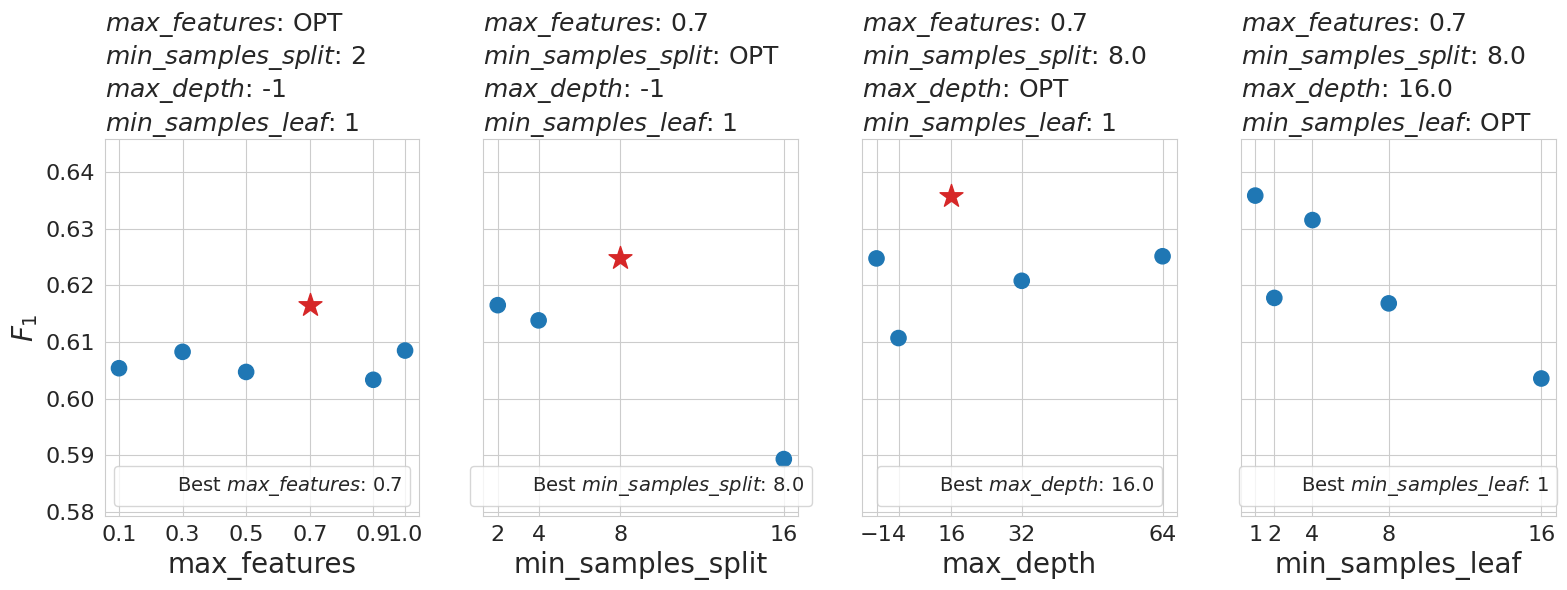

In [408]:
dt_hparams_order = {
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_split': [2, 4, 8, 16],
    'max_depth': [4, 16, 32, 64, -1],
    'min_samples_leaf': [1, 2, 4, 8, 16],
}

dt_hparams_default = {
    'max_features': 1.0,
    'min_samples_split': 2,
    'max_depth': -1,
    'min_samples_leaf': 1,
}

dt_abf_fig = plot_all_hparams_optimization(decision_tree, "agg_beat_features", dt_hparams_order, dt_hparams_default)

In [409]:
dt_abf_fig.savefig("plots/dt_abf_opt.pdf", bbox_inches="tight")

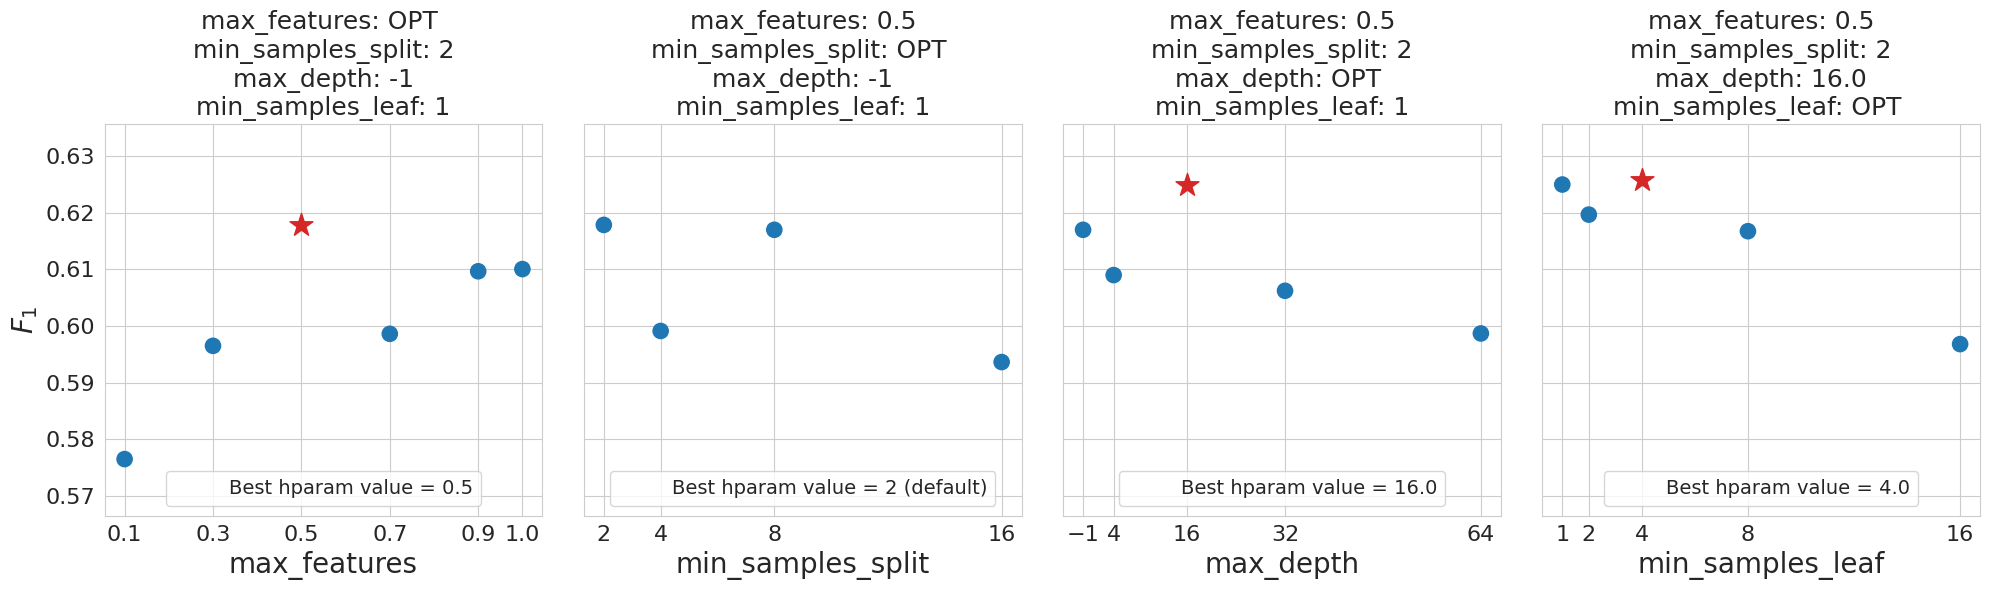

In [364]:
dt_hparams_default = {
    'max_features': 1.0,
    'min_samples_split': 2,
    'max_depth': -1,
    'min_samples_leaf': 1,
}

plot_all_hparams_optimization(decision_tree, "whole_signal_features", dt_hparams_order, dt_hparams_default)

In [380]:
names = ["abc", "abcabcabc", "abc"]
vals = [123, 123123123, 123]

for name, val in zip(names, vals):
    print(f"{name:>25}: {val}")

                      abc: 123
                abcabcabc: 123123123
                      abc: 123
